# Finite difference operations

At the end of this notebook, you will have learned how to...

1. Use finite difference approximations to derive equations.
2. Apply this to the 2D steady-state heat equation and solve a linear system of equations.
3. Create periodic boundary conditions to simulate lateral variations in surface temperature.
4. (if we have time...) code your own finite difference approximation to the heat equation for variable diffusivity.
5. Solve temperature over complex geometries imported from GoCAD.

In [2]:
# load the appropriate python modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Finite difference approximations

Ideally, an analytical solution would be obtained by integrating this equation with a set of boundary conditions.
Unfortunately finding a solution is not a trivial task and may only satisfy a very specific topic you are interested in solving.
The finite difference method approximates solutions to differential equations across a discreet domain with a set of boundary conditions along the edges of this domain.

<img src="images/fd.png" width="600">

As you can gather from the above image, resolution is important.
If $h$ is too large the solution is not very accurate, and with time time-dependence it could become *unstable*.

Lets take a simple function, $f(x) = \sin (x)$. We can calculate its derivatives analytically:

$$\begin{align}
f'(x) &= \cos (x) \\
f''(x) &= -\sin (x)
\end{align}$$

or we could use finite differences to approximate the derivatives...

$$\begin{align}
f'(x) &= \lim_{h\to0} \frac{f(x+h) - f(x)}{h} \\
f''(x)&= \lim_{h\to0} \frac{f(x+2h) - 2f(x+h) + f(x)}{h^2}
\end{align}$$

---

> **EXERCISE 1** Play around with the code below to see what happens when you change $f(x)$ and vary $h$.

---

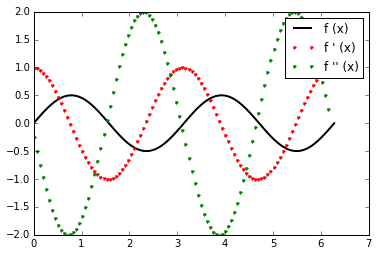

In [3]:
# "Resolution"
#  Try a few different values  

number_of_points = 150

# Data

x = np.linspace(0,2*np.pi,number_of_points)
xh = np.linspace(0,2*np.pi,1000) # 1000 is more than enough to plot

f = np.sin(x)
fh = np.sin(xh)
dfh = np.cos(xh)
d2fh = -fh

# Normalization
h = x[1] - x[0] # use np.diff(x) if x is not uniform

# First derivatives
df = np.diff(f) / h # numpy version
for i in x[:-1]:
    df[i] = (f[i+1]-f[i]) / h

# Second derivatives
ddf = np.diff(f, 2) / h**2 # numpy version
for i in x[:-2]:
    ddf[i] = (f[i+2]-2*f[i+1]+f[i]) / h**2

# Plotting
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.plot(x, f, 'black', linewidth=0.0, marker="+", markersize=12, label="f (x)")
ax1.plot(x[:-1], df, 'red', linewidth=0.5, marker="+", markersize=12, label="f ' (x)")
ax1.plot(x[:-2], ddf, 'green', linewidth=0.5, marker="+", markersize=12, label="f '' (x)")

ax1.plot(xh, fh, 'black', lw=2, label="f (x)")
ax1.plot(xh, dfh, 'red', lw=2, label="f ' (x)")
ax1.plot(xh, d2fh, 'green', lw=2, label="f '' (x)")

ax1.legend()
plt.show()

The useful part of this is that we can derive an equation without knowing any calculus!
(Not that we recommend that!)

Finite difference is just one of many techniques that fall under the umbrella of *numerical modelling*.
Finite difference works by taking the average of neighbouring nodes within the domain to calculate the value on a specific node, $N_{i,j}$.
In 2D these neighbouring nodes would be $N_{i-1,j}, N_{i,j+1}, N_{i+1,j}, N_{i,j-1}$.

<img src="images/fd_ij.png" width="500">

## 2. Finite difference approximations to the heat equation

The 2D heat equation is given as:

$$\rho c_p \frac{\partial T}{\partial t} = \kappa \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right) + H$$

where $\rho$ is density, $c_p$ is specific heat capacity, $\kappa$ is the thermal diffusivity coefficient, and $H$ are heat sources.

There are a few different ways to average - forward, backward, and central.
For the heat equation we are going to use the 2nd order central difference, which applied to the heat equation is:

$$\kappa \left( \frac{T_{i,j-1}-2T_{i,j}+T_{i,j+1}}{\Delta x^2} + \frac{T_{i-1,j}-2T_{i,j}+T_{i+1,j}}{\Delta y^2} \right) = -H$$

Note that we have made $\rho c_p \frac{\partial T}{\partial t} = 0$ because initially we are only going to solve this in steady-state.
Expanding the brackets and collecting like terms ($T_{i,j-1}, T_{i-1,j}, T_{i,j}, T_{i+1,j}, T_{i,j+1}$) we get,

$$\left[\kappa\frac{T_{i,j-1}}{\Delta y^2}\right] + \left[\kappa\frac{T_{i-1,j}}{\Delta x^2}\right] - \left[\kappa\frac{2T_{i,j}}{\Delta x^2} - \kappa\frac{2T_{i,j}}{\Delta y^2}\right] + \left[\kappa\frac{T_{i+1,j}}{\Delta x^2}\right] + \left[\kappa\frac{T_{i,j+1}}{\Delta y^2}\right] = -H_{i,j}$$

$H$ can be constant or spatially variable, $H_{i,j}$, it doesn't matter.

### 2.1 Solving a system of linear equations

You may have noticed that finite differences are linear approximations of a derivative.
Linear systems of equations are, it just so happens, very easy to solve using a computer!
The way to go about this is to build a matrices in the form,

$$\mathbf{A x = b}$$

- $\mathbf{A}$ is a square matrix, of shape `[n,n]`, that contains the finite difference operations.
- $\mathbf{b}$ contains our heat source terms, $H$, and has a shape `[1,n]`.
- $\mathbf{x}$ is the temperature matrix, of shape `[1,n]`, for which we wish to solve.

Here is a rectangular grid of nodes that we want to compute some finite difference operators on...

<img src="images/fd_nodes.png" width="500">

Using the finite difference approximation for constant diffusivity, $\kappa$, the matrices will look like:

$$\mathbf{A} = 
\begin{bmatrix}
\frac{\kappa}{\Delta y^2} & \cdots & \frac{\kappa}{\Delta x^2} & (\frac{-2\kappa}{\Delta x^2}+\frac{-2\kappa}{\Delta y^2}) & \frac{\kappa}{\Delta x^2} & \cdots & \frac{\kappa}{\Delta y^2} & 0 & 0 & \cdots \\
0 & \frac{\kappa}{\Delta y^2} & \cdots & \frac{\kappa}{\Delta x^2} & (\frac{-2\kappa}{\Delta x^2}+\frac{-2\kappa}{\Delta y^2}) & \frac{\kappa}{\Delta x^2} & \cdots & \frac{\kappa}{\Delta y^2} & 0 & \cdots \\
\vdots &  & \ddots &  & \ddots & \ddots &  & \ddots & & \vdots \\
\cdots & 0 & 0 & \frac{\kappa}{\Delta y^2} & \cdots & \frac{\kappa}{\Delta x^2} & (\frac{-2\kappa}{\Delta x^2}+\frac{-2\kappa}{\Delta y^2}) & \frac{\kappa}{\Delta x^2} & \cdots & \frac{\kappa}{\Delta y^2}
\end{bmatrix}$$

$$\mathbf{x} =
\begin{bmatrix}
T_{9} \\ T_{10} \\ \vdots \\ T_{n}
\end{bmatrix}
\quad \mathbf{b} = 
\begin{bmatrix}
-H_{9} \\ -H_{10} \\ \vdots \\ -H_{n}
\end{bmatrix}
$$

In [8]:
nx, ny = 27, 25
nodes = np.arange(nx*ny).reshape(ny,nx)
dx, dy = 1., 1.

# Create matrix structures
A_matrix = np.zeros((nx*ny,nx*ny)) # square matrix
b_matrix = np.zeros(nx*ny)

# field variables
H = 2e-6
k = 3.0

# boundary conditions (constant temperature)
topBC = 300.0
bottomBC = 800.0
leftBC = 500.0
rightBC = 500.0

# boundary nodes
top_nodes = nodes[0,:]
bottom_nodes = nodes[-1,:]
left_nodes = nodes[1:-1,0]
right_nodes = nodes[1:-1,-1]

for idx in top_nodes:
    A_matrix[idx, idx] = 1.0
    b_matrix[idx] = topBC
for idx in bottom_nodes:
    A_matrix[idx, idx] = 1.0
    b_matrix[idx] = bottomBC
for idx in left_nodes:
    A_matrix[idx, idx] = 1.0
    b_matrix[idx] = leftBC
for idx in right_nodes:
    A_matrix[idx, idx] = 1.0
    b_matrix[idx] = rightBC

bmask = np.zeros_like(nodes, dtype=bool)
bmask[1:-1,1:-1] = True # these are nodes that do not intersect the boundary

for idx in nodes[bmask]:
    A_matrix[idx, idx-nx] = k/dy**2
    A_matrix[idx, idx-1]  = k/dx**2
    A_matrix[idx, idx]    = -2*k/dx**2 -2*k/dy**2
    A_matrix[idx, idx+1]  = k/dx**2
    A_matrix[idx, idx+nx] = k/dy**2
    
    b_matrix[idx] = -H

print A_matrix

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


The $\mathbf{A}$ matrix is tridiagonal, which means that there are a lot of zeros.
Since the data only takes up a fraction of the matrix, we could use [scipy's sparse module](http://docs.scipy.org/doc/scipy/reference/sparse.html) to conserve memory:

    from scipy import sparse

Below we use numpy's linear algebra solver and plot the temperature field.

---

> **EXERCISE 2** Change the boundary conditions, heat production, and conductivity above then plot the result below.

---

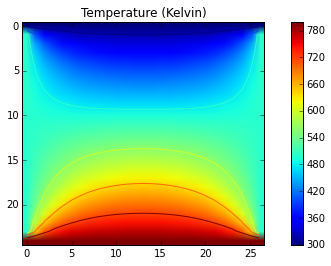

In [9]:
temperature = np.linalg.solve(A_matrix, b_matrix) # solve x matrix

fig = plt.figure(1, figsize=(10,4))
ax1 = fig.add_subplot(111)

im = ax1.imshow(temperature.reshape(ny,nx))
ax1.set_title('Temperature (Kelvin)')
ax1.contour(temperature.reshape(ny,nx)) # Lets plot some contours

fig.colorbar(im)
plt.show()

## 3. Boundary conditions

In the previous exercise we used constant temperature boundary conditions on each wall in the model domain.
These are Dirichelet boundary conditions:

$$T(n) = T_{\text{boundary}}$$

The other boundary condition we want to use is Neumann, or flux, boundary conditions:

$$\frac{\partial T}{\partial y}(n) = -\mathbf{q} = -\kappa \frac{\partial T}{\partial y}$$

in the $y$ direction for example, where $\mathbf{q}$ is the flux vector assigned to a wall of the domain.
For insulated boundary conditions, $\mathbf{q}=0$.
This means that no heat enters or escapes from that boundary.
For example, the finite difference form for this on the left wall of our domain would be:

$$ \kappa \frac{T_{i,j}-T_{i+1,j}}{\Delta x^2} = \frac{\mathbf{q}}{\Delta x} - H$$

which reduces to

$$ \kappa \frac{T_{i,j}-T_{i+1,j}}{\Delta x^2} = - H$$

when $\mathbf{q}=0$ 

### 3.1 Periodic boundary conditions

In the next exercise you will need to assign Neumann boundary conditions to all walls of the domain; except the top wall where you will assign a periodic Dirichlet boundary condition described by the equation:

$$T_\text{surface} = T_0 + \Delta T \cos \frac{2\pi x}{\lambda}$$

Such surface temperature variations can arise as a result of topographic undulations and the altitude dependence of temperature in the Earth’s atmosphere.
Horizontal surface temperature variations also occur at the boundaries between land and bodies of water, such as lakes or seas.

---

> **EXERCISE 3** Create a periodic surface temperature boundary condition using the code above, then make the rest of the walls insulated.

---

In [ ]:
# Empty space for your code
# Copy the code you made above as a template

Lucky there is an analytical solution to test if your code is working correctly...

$$T(x,y) = T_0 + \Delta T \cos \frac{2 \pi x}{\lambda} e^{-2\pi y/\lambda}$$

Set your Neumann boundary conditions to zero and use this to *benchmark* your code.
Plot the results using `matplotlib`.

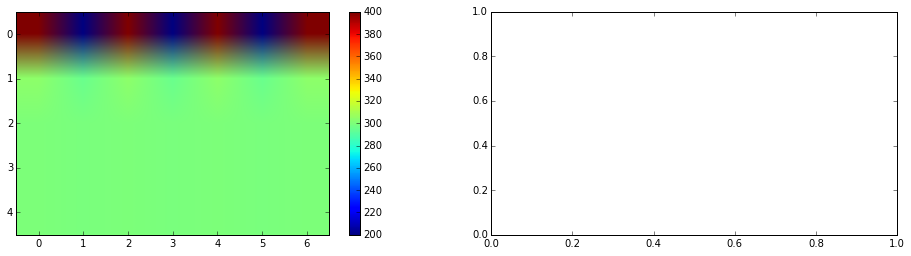

In [60]:
x, y = np.meshgrid( np.arange(0,nx), np.arange(0,ny) )
lamb = 2.

T_analytical = 300. + 100.0*np.cos(2*np.pi*x/lamb) * np.exp(-2*np.pi*y/lamb)


fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

# Analytical solution
im1 = ax1.imshow(T_analytical.reshape(ny,nx))
fig.colorbar(im1, ax=ax1)

# Numerical solution
## YOUR CODE GOES HERE

plt.show()